데이터 확인

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [17]:
# 데이터셋 불러오기
(ds, ds_info) = tfds.load(
    'tf_flowers',
    split='train',
    as_supervised=True,
    with_info=True
)

# 전체 데이터 개수
print("총 데이터 수:", ds_info.splits['train'].num_examples)

# 클래스 개수
print("클래스 수:", ds_info.features['label'].num_classes)

# 클래스 이름
print("클래스 이름:", ds_info.features['label'].names)

총 데이터 수: 3670
클래스 수: 5
클래스 이름: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [18]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [19]:
(ds, ds_info) = tfds.load(
    'tf_flowers',
    split='train',
    as_supervised=True,
    with_info=True
)

TOTAL = ds_info.splits['train'].num_examples
print("전체 데이터 수:", TOTAL)

전체 데이터 수: 3670


In [20]:
# Train / Val / Test 분할 (8:1:1)

train_size = int(TOTAL * 0.8)
val_size   = int(TOTAL * 0.1)
test_size  = TOTAL - train_size - val_size

ds = ds.shuffle(1000, seed=42)

ds_train = ds.take(train_size)
ds_rest  = ds.skip(train_size)

ds_val  = ds_rest.take(val_size)
ds_test = ds_rest.skip(val_size)

In [21]:
# 이미지 전처리 함수
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    return image, label


In [22]:
#데이터 증강 레이어

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label


In [23]:
# Batch 데이터셋 만들기
train_batches = (ds_train
                 .map(format_image, num_parallel_calls=AUTOTUNE)
                 .map(augment, num_parallel_calls=AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTOTUNE))

validation_batches = (ds_val
                      .map(format_image, num_parallel_calls=AUTOTUNE)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTOTUNE))

test_batches = (ds_test
                .map(format_image, num_parallel_calls=AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE))


In [24]:
for images, labels in train_batches.take(1):
    print("images shape:", images.shape)
    print("labels shape:", labels.shape)

images shape: (32, 224, 224, 3)
labels shape: (32,)


In [25]:
# VGG16 기반 모델 만들기


NUM_CLASSES = ds_info.features['label'].num_classes  # = 5

# VGG16 불러오기 (base model)
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 처음에는 가중치 고정
base_model.trainable = False

# 모델 구성
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# 구조 확인
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

In [26]:
# 모델 컴파일
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
# 모델 학습 시작
EPOCHS = 15

history = model.fit(
    train_batches,
    validation_data=validation_batches,
    epochs=EPOCHS
)

Epoch 1/15
92/92 [==============================] - 22s 227ms/step - loss: 3.2970 - accuracy: 0.4029 - val_loss: 1.0590 - val_accuracy: 0.7030
Epoch 2/15
92/92 [==============================] - 20s 215ms/step - loss: 1.7734 - accuracy: 0.5937 - val_loss: 0.8833 - val_accuracy: 0.7657
Epoch 3/15
92/92 [==============================] - 20s 214ms/step - loss: 1.3489 - accuracy: 0.6516 - val_loss: 0.7007 - val_accuracy: 0.8174
Epoch 4/15
92/92 [==============================] - 20s 215ms/step - loss: 1.1145 - accuracy: 0.6965 - val_loss: 0.7012 - val_accuracy: 0.7902
Epoch 5/15
92/92 [==============================] - 20s 215ms/step - loss: 0.9226 - accuracy: 0.7350 - val_loss: 0.5894 - val_accuracy: 0.8311
Epoch 6/15
92/92 [==============================] - 20s 215ms/step - loss: 0.8275 - accuracy: 0.7544 - val_loss: 0.4509 - val_accuracy: 0.8556
Epoch 7/15
92/92 [==============================] - 20s 215ms/step - loss: 0.7461 - accuracy: 0.7626 - val_loss: 0.4251 - val_accuracy: 0.8365

In [28]:
#Test 데이터 정확도 확인

test_loss, test_acc = model.evaluate(test_batches)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


12/12 [==============================] - 1s 111ms/step - loss: 0.3317 - accuracy: 0.8610
Test Accuracy: 86.10%


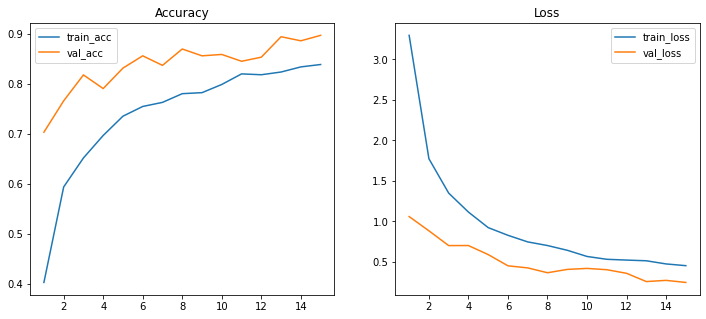

In [29]:
# 학습 과정 시각화
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='train_acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.legend()

plt.show()


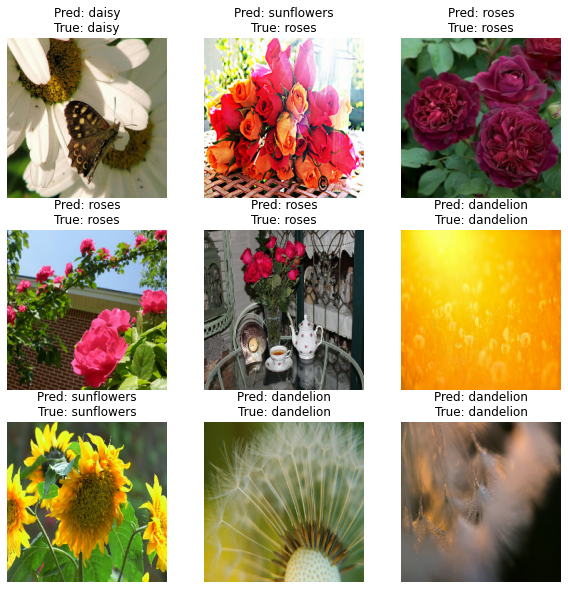

In [30]:
#예측 결과 시각화

import numpy as np

class_names = ds_info.features['label'].names

for images, labels in test_batches.take(1):
    preds = model.predict(images)

    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        pred_label = class_names[np.argmax(preds[i])]
        true_label = class_names[labels[i]]

        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis("off")

    plt.show()


In [31]:
# 모델 활용

# 단일 이미지 예측 코드
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class_names = ds_info.features['label'].names

def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))

    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]

    plt.imshow(img)
    plt.title(f"Predicted: {pred_class}")
    plt.axis('off')
    plt.show()


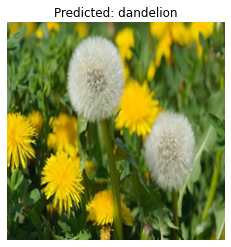

In [40]:
# 인터넷에서 직접 가져온 꽃 사진
predict_image("/aiffel/aiffel/project/data/dandelion.jpg")

실사진 추론: 성공 (민들레 맞춤)

✅ 정리


VGG16 기반의 사전학습 모델을 활용하여 Transfer Learning을 수행하였다.

학습 과정에서 데이터 증강과 Dropout, Batch Normalization 기법을 적용하여 과적합을 방지하였다. 

그 결과 test 데이터셋 기준으로 약 86.10%의 정확도를 달성하였다. 또한 학습곡선 시각화 및 임의 이미지 추론 결과를 통해 모델 성능을 확인하였다.